## 1. Setup

In [5]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
%%R

# My commonly used R imports
require('flexplot')
require('tidyverse')
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: flexplot
Loading required package: tidyverse
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘flexplot’


## 2. Load multivariable file and plot charts

In [8]:
%%R -o df
df <- read_csv('processed_data/2023_subway_censusvar_multire.csv')

Rows: 18208 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (27): Common Name, Equipment Description, Executive Comment, outage_cod...
dbl  (21): GEOID, Outage, Station MRN, Station ID, Complex ID, lat, long, AD...
dttm  (4): Out of Service Date, Estimated Return to Service Date, Actual Ret...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 1D charts

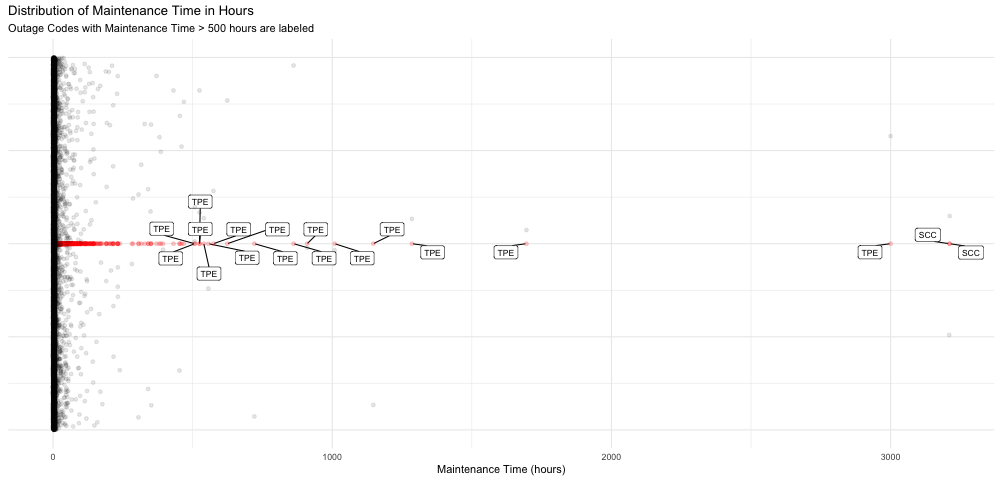

In [9]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    # filter(maintenance_time < 250) %>%
    ggplot() +
    aes(x = maintenance_time, y=1) +
    # for dots with maintenance_time > 1000 add text of their outage codes
    # increase max.overlaps to avoid overlapping text
    geom_label_repel(aes(label = ifelse(maintenance_time > 500, outage_code, '')), size = 3, box.padding = 0.5, max.overlaps=Inf) +
    geom_boxplot(color = 'red', alpha=.2) +
    geom_jitter(alpha = 0.1) +
    theme_minimal() +
    theme(axis.text.y = element_blank(), axis.title.y = element_blank()) +
    labs(title = 'Distribution of Maintenance Time in Hours', subtitle = 'Outage Codes with Maintenance Time > 500 hours are labeled', x = 'Maintenance Time (hours)') 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Groups with fewer than two data points have been dropped. 

R[write to console]: 2: Groups with fewer than two data points have been dropped. 

R[write to console]: 3: Groups with fewer than two data points have been dropped. 

R[write to console]: 4: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf

R[write to console]: 5: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf

R[write to console]: 6: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf



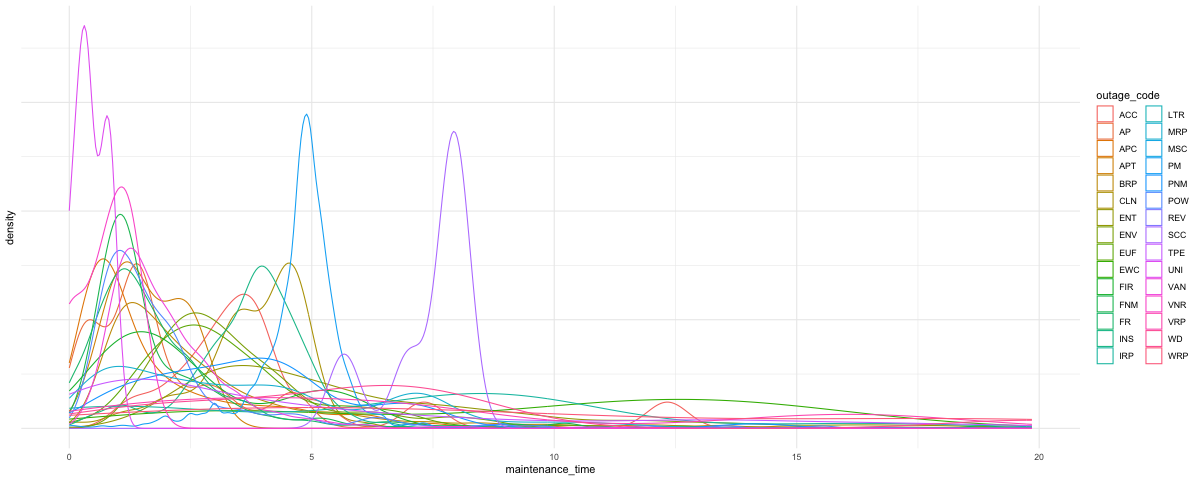

In [129]:
%%R -w 1200

df %>%
    filter(!is.na(maintenance_time)) %>%
    filter(maintenance_time < 20) %>%
    ggplot() +
    aes(x = maintenance_time, color=outage_code) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 

## 3. Multivariable regression 

**Initial thought**
- Y= Time to repair (FOIL)
- X1= Outage code (FOIL data) - `outage_code`
- X2= Ridership in each tract (Census Data) - `sub_pop_estimate`
- X3= Median income (Census Data) - `med_earn_estimate`
- X4= Elevated or subway (merged from subway location dataset to FOIL dataset) `Structure`

In [14]:
%%R

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + Structure + amb_pop_estimate + sub_pop_estimate, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    Structure + amb_pop_estimate + sub_pop_estimate, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.82   -2.72   -0.73    1.23 2934.42 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.665e+01  1.785e+01   3.735 0.000189 ***
outage_codeAP     -1.909e+00  1.498e+01  -0.127 0.898635    
outage_codeAPC     4.938e-01  1.501e+01   0.033 0.973763    
outage_codeAPT    -7.302e-01  2.733e+01  -0.027 0.978684    
outage_codeBRP     7.253e-01  1.485e+01   0.049 0.961032    
outage_codeCCR     2.270e+02  5.342e+01   4.249 2.16e-05 ***
outage_codeCLN     2.714e-01  1.604e+01   0.017 0.986497    
outage_codeENT     3.516e+00  1.495e+01   0.235 0.814007    
outage_codeENV    -3.021e-01  1.513e+01  -0.020 0.984069    
outage_codeEUF     1.573e-02  1.546e+01   0.001 0.999188    
outage_codeEWC     1.181e+01  2.019e+01   0.585 0.558527    
outage_codeFIR    -1.

## 3-5. Interesting findings?

Aishi added that perhaps some maintenance naturally takes more time. So perhaps we could try to control the maintenance type and look at what variables are affecting repair time. 

We start with looking at the outage codes with low p-values from the preliminary multivariable regression, which are
- WRP (Warranty Repair by Rehabilitation / Replacement Contractor)
- TPE
- SCC (Capital - Contract Rehab on Station - Machine OK)
- LTR (Long-term repair)
- CCR(Critical Component Replacement)

We found that, of all outage codes, TPE is a frequently occurring outage, so we filter it down to **TPE** outages only and run a multivariable regression with the rest of the variables.

It looks like **median income of a census tract** has an influence on how long the maintenance time would take. But we’ll have to try other variables to find out what other factors are affecting the repair time since the R-squared isn’t high. 


In [16]:
df[df['outage_code'] == 'TPE']

,GEOID,Out of Service Date,Common Name,Outage,Equipment Description,Executive Comment,outage_code,Status,External Source Note,Reason Shown to Public,...,geometry,population_estimate,sub_pop_estimate,amb_pop_estimate,med_earn_estimate,population_moe,sub_pop_moe,amb_pop_moe,med_earn_moe,maintenance_time
2539,3.604700e+10,2023-02-10 07:30:00+00:00,EL327X,807554.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,127.483333
2553,3.604700e+10,2023-05-18 19:19:00+00:00,EL327X,868342.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,51.433333
2618,3.604700e+10,2023-02-08 08:26:00+00:00,EL327X,806677.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,4.000000
2655,3.604700e+10,2023-05-09 07:13:00+00:00,EL327X,850886.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,98.066667
2659,3.604700e+10,2023-05-17 14:17:00+00:00,EL327X,866086.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,19.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18020,3.608109e+10,2023-07-19 07:47:00+00:00,EL494X,897095.0,ELE: EL494X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,32.216667
18021,3.608109e+10,2023-02-14 20:00:00+00:00,EL491X,809054.0,ELE: EL491X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,524.883333
18022,3.608109e+10,2023-02-10 07:39:00+00:00,EL490X,807557.0,ELE: EL490X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,143.700000
18023,3.608109e+10,2023-01-09 10:10:00+00:00,EL491X,794280.0,ELE: EL491X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,861.483333


In [15]:
%%R

df %>%
    filter(outage_code == 'TPE') %>%
    # plot scatter plot of maintenance_time vs med_earn_estimate
    select(maintenance_time) %>%
    summary()

 maintenance_time   
 Min.   :   0.0833  
 1st Qu.:   3.2833  
 Median :  21.5833  
 Mean   :  66.2472  
 3rd Qu.:  50.1167  
 Max.   :2999.9167  
 NA's   :2          


In [16]:
%%R

df %>%
    filter(outage_code == 'TPE') %>%
    lm(maintenance_time ~ med_earn_estimate + sub_pop_estimate + amb_pop_estimate + Structure, data = .) %>%
    summary()


Call:
lm(formula = maintenance_time ~ med_earn_estimate + sub_pop_estimate + 
    amb_pop_estimate + Structure, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-162.47  -43.96  -37.06   -5.32 2916.91 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.498e+02  6.977e+01   3.580 0.000372 ***
med_earn_estimate -6.719e-04  1.721e-04  -3.904 0.000106 ***
sub_pop_estimate   1.200e-02  2.943e-02   0.408 0.683650    
amb_pop_estimate  -3.978e-04  9.881e-03  -0.040 0.967903    
StructureElevated -7.016e+01  7.447e+01  -0.942 0.346502    
StructureSubway   -9.375e+01  6.242e+01  -1.502 0.133677    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 186.9 on 583 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.04136,	Adjusted R-squared:  0.03314 
F-statistic:  5.03 on 5 and 583 DF,  p-value: 0.0001601



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation:
colour.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



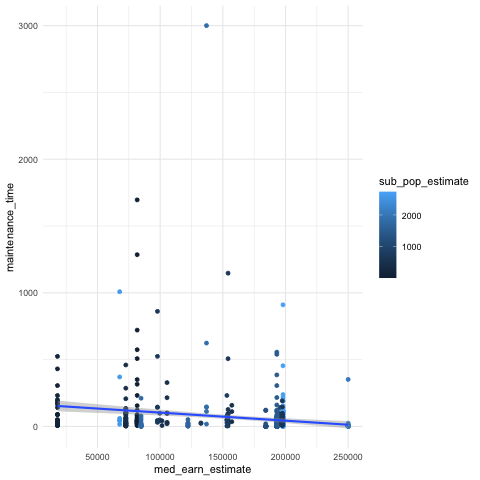

In [13]:
%%R


df %>%
    filter(outage_code == 'TPE') %>%
    # plot scatter plot of maintenance_time vs med_earn_estimate
    ggplot() +
    aes(x = med_earn_estimate, y = maintenance_time, color=sub_pop_estimate) +
    geom_point() +
    geom_smooth(method = 'lm') +
    theme_minimal() 
# model <- lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate , data = df2)
# model_summary <- summary(model)
# model_summary



## 4. Plot response variable chart

In [74]:
%%R
# keep only outage_code + sub_pop_estimate + med_earn_estimate + Structure + Borough + population_estimate + maintenance_time in df_model
df_model <- df %>%
    select(outage_code, sub_pop_estimate, med_earn_estimate, Structure, Borough, population_estimate, maintenance_time)

# pivot df_model from wide to long using pivot_longer on all columns except the index 
# and the column we want to predict (maintenance_time)
df_long <- df_model %>%
    pivot_longer(cols = -c(outage_code, Structure, Borough, maintenance_time), names_to = "variable", values_to = "value")

df_long


# A tibble: 54,624 × 6
   outage_code Structure Borough maintenance_time variable            value
   <chr>       <chr>     <chr>              <dbl> <chr>               <dbl>
 1 PM          Subway    Bx                  4.75 sub_pop_estimate     1004
 2 PM          Subway    Bx                  4.75 med_earn_estimate   21962
 3 PM          Subway    Bx                  4.75 population_estimate  5681
 4 BRP         Subway    Bx                  7.83 sub_pop_estimate     1004
 5 BRP         Subway    Bx                  7.83 med_earn_estimate   21962
 6 BRP         Subway    Bx                  7.83 population_estimate  5681
 7 INS         Subway    Bx                  3.55 sub_pop_estimate     1004
 8 INS         Subway    Bx                  3.55 med_earn_estimate   21962
 9 INS         Subway    Bx                  3.55 population_estimate  5681
10 ENT         Subway    Bx                  3.78 sub_pop_estimate     1004
# ℹ 54,614 more rows
# ℹ Use `print(n = ...)` to see more rows


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`). 



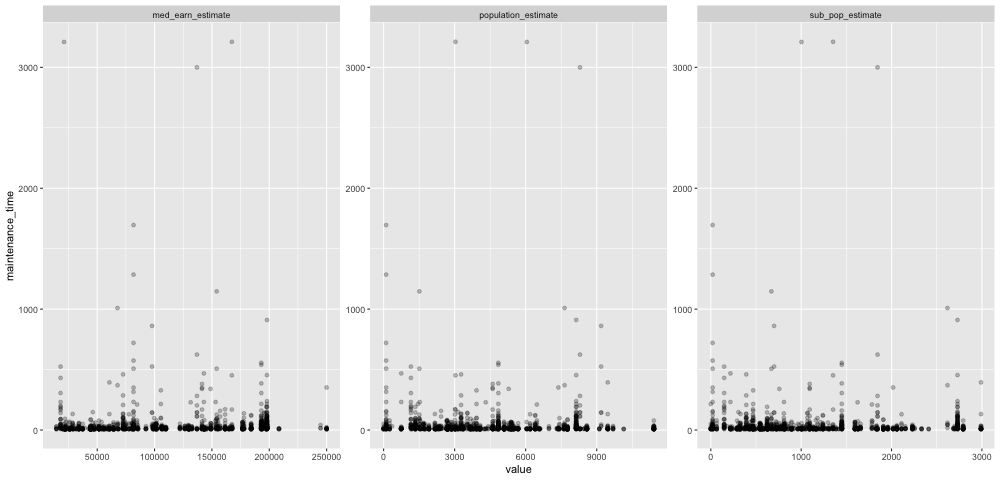

In [83]:
%%R -w 1000

# look at the outliers 
# maintenance_time > 7.3 (mean)
df_long %>%
        filter(maintenance_time > 7.3) %>%
        ggplot() +
        aes(x=value, y=maintenance_time) +
        geom_point(alpha=.25) + 
        # geom_smooth(method = "lm") +
        facet_wrap(~variable, scales = "free")
